In [104]:
import numpy as np
import xgboost as xgb

import spacy
import itertools 
from math import log
from collections import defaultdict

class InvertedIndex:
    def __init__(self):
        ## You should use these variable to store the term frequencies for tokens and entities...
        # {key: token/entity, value: {key: doc_id, value: normalised term frequency(token/entity, doc_id)}}
        self.tf_tokens = defaultdict(dict)
        self.tf_entities = defaultdict(dict)

        ## You should use these variable to store the inverse document frequencies for tokens and entities...
        # {key: token/entity, value: IDF(token/entity)}
        self.idf_tokens = {}
        self.idf_entities = {}
        
        # load the english language model
        self.nlp = spacy.load("en_core_web_sm")

    # count lemma in description for each candidate entity 
    def _count_tf_tokens(self, parsed_entity_page):
        # tf_count - key: token_lemma, 
        # value: {key: candidate entity, value: # of this lemma in this entity's description}
        token_tf_count = defaultdict(lambda:defaultdict(int))
        
        for ent in parsed_entity_page:
            description = parsed_entity_page[ent]
            for _,_,lemma,_,_ in description:
                token_tf_count[lemma][ent] += 1
        return token_tf_count
        
    # count term frequencies for entities and tokens in the documents       
    def _count_tf(self, documents):
        # tf_count - key: term, value: {key: doc_id, value: # of this term in this doc_id}
        entity_tf_count = defaultdict(lambda:defaultdict(int))
        token_tf_count = defaultdict(lambda:defaultdict(int))

        # documents: key - doc_id; value: document_text
        for doc_id in documents.keys():
            doc_text = self.nlp(documents[doc_id])

            # decide to calculate entities first, because single word entities 
            #should not be counted as tokens, if tokens calculated first, extra deleting
            #cost to token list
            single_word_entities = defaultdict(list)
            
            # count tf for entities
            for ent in doc_text.ents:
                entity_tf_count[ent.text][doc_id] += 1

                # if entity is a single word
                if len(ent.text.split()) == 1:
                    single_word_entities[ent.text].append(ent.start_char)

            # count tf for tokens       
            for token in doc_text:
                if not token.is_stop and not token.is_punct:
                    is_single_entity = False
                    # ent_iob - 3: begin entity, 2: outside, 1: inside
                    if (token.ent_iob == 1 or token.ent_iob == 3) \
                      and token.text in single_word_entities.keys() \
                      and token.idx in single_word_entities[token.text]:
                        is_single_entity = True

                    if not is_single_entity:
                        token_tf_count[token.text][doc_id] += 1
                
        return entity_tf_count, token_tf_count
    
    # calculate tf and idf of tokens
    def _calc_tf_idf_token(self, token_tf_count, total_doc_no):
        for token in token_tf_count.keys():
            # calculate tf
            for doc_id in token_tf_count[token]:
                tf_token = token_tf_count[token][doc_id]
                # calculate normalised token tf
                self.tf_tokens[token][doc_id] = 1.0 + log(1.0 + log(tf_token))

            # calculate token idf
            doc_contain_token = len(token_tf_count[token])
            self.idf_tokens[token] = 1.0 + log(total_doc_no / (1.0 + doc_contain_token))
        return

    # calculate tf and idf of entities
    def _calc_tf_idf_entity(self, entity_tf_count, total_doc_no):
        for ent in entity_tf_count:
            # calculate tf
            for doc_id in entity_tf_count[ent]:
                tf_ent = entity_tf_count[ent][doc_id]

                # calculate normalised entity tf
                self.tf_entities[ent][doc_id] = 1.0 + log(tf_ent)

            # calculate entity idf
            doc_contain_ent = len(entity_tf_count[ent])
            self.idf_entities[ent] = 1.0 + log(total_doc_no / (1.0 + doc_contain_ent))
        return    
        
    ## Your implementation for indexing the documents...
    # add parameter is_dscp: True for input doc is parsed entity description, else normal doc
    def index_documents(self, documents, is_dscp):
        total_doc_no = len(documents)
        
        if is_dscp:
            token_tf_count = self._count_tf_tokens(documents)
            self._calc_tf_idf_token(token_tf_count, total_doc_no)
        else:
            # get term frequencies
            entity_tf_count, token_tf_count = self._count_tf(documents)
            
            # use tf to calculate normalised tf and idf
            self._calc_tf_idf_token(token_tf_count, total_doc_no)
            self._calc_tf_idf_entity(entity_tf_count, total_doc_no)


    ## Your implementation to return the max score among all the query splits...
    # avg_score: if True, get mean tf-idf score, else, get sum 
    def max_score_query(self, query_splits, doc_id, score_type):
        ## Output should be a tuple (max_score, {'tokens': [...], 'entities': [...]})
        max_score = 0
        max_score_split = {}
        for key, split in query_splits.items():
            curr_tokens = split['tokens']

            score_tokens = []
            for token in curr_tokens:
                if token in self.tf_tokens.keys() and doc_id in self.tf_tokens[token].keys():
                    score_tokens.append(self.tf_tokens[token][doc_id] * self.idf_tokens[token])
            
            scorei = 0.0 
            if len(score_tokens) > 0:
                if score_type == 'avg':
                    scorei = sum(score_tokens) / len(curr_tokens)
                elif score_type == 'sum':
                    scorei = sum(score_tokens)
                elif score_type == 'max':
                    scorei = max(score_tokens)
                
            
            if scorei > max_score:
                max_score = scorei
                max_score_split = split
            
        return (max_score, max_score_split)

    
def get_groups(train_mentions):
    # get no. of groups == no. of mentions in train_mentions
    n_groups = len(train_mentions)

    # get size of each group and store in train_groups
    train_groups = np.zeros(n_groups, dtype=int)

    # groups is formed in ascending order of key of train_mentions (mention_id)
    mention_ids = list(train_mentions.keys())
    mention_ids.sort()

    idx = 0
    for mention_id in mention_ids:
        train_groups[idx] = len(train_mentions[mention_id]['candidate_entities'])
        idx += 1
    return train_groups, mention_ids
    
# helper Feature: calculate avg tf-idf for each mention
def get_mention_tfidf(mention_ids, mentions, doc_index):
    mention_tfidf = []
    idx = 0
    for mention_id in mention_ids:
        mention = mentions[mention_id]['mention']
        doc_title = mentions[mention_id]['doc_title']
        no_candidates = len(mentions[mention_id]['candidate_entities'])

        # split mention to tokens
        split = {1: {'entities': [], 'tokens': mention.split()}}
        score, _ = doc_index.max_score_query(split, doc_title, 'avg')
        
        mention_tfidf += no_candidates * [score]
        
    return mention_tfidf

# feature: calculate avg tf-idf for each candidate entity
def get_candidate_ent_tfidf(mention_ids, mentions, doc_index):
    ent_tfidf = []
    for mention_id in mention_ids:
        doc_title = mentions[mention_id]['doc_title']
        c_ents = mentions[mention_id]['candidate_entities']
        for ent in c_ents:
            split = {1: {'entities': [], 'tokens': ent.split('_')}}
            score, _ = doc_index.max_score_query(split, doc_title, 'avg')
            
            ent_tfidf.append(score)
    return ent_tfidf

# feature: get candidate entity description tfidf
def get_ent_dscp_tfidf(mention_ids, mentions, parsed_entity_pages, doc_index):
    ent_dscp_tfidf = []
    for mention_id in mention_ids:
        doc_title = mentions[mention_id]['doc_title']
        c_ents = mentions[mention_id]['candidate_entities']
        for ent in c_ents:
            dscp = parsed_entity_pages[ent]
            dlemmas = [lemma for _,_,lemma,_,_ in dscp]
            split = {1: {'entities': [], 'tokens': dlemmas}}
            score, _ = doc_index.max_score_query(split, doc_title, 'avg')
            
            ent_dscp_tfidf.append(score)
    return ent_dscp_tfidf

# feature: mention and ent exactly match or not
def get_mention_ent_match(mention_ids, mentions):
    mention_ent_match = []
    for mention_id in mention_ids:
        mention = mentions[mention_id]['mention']
        mtokens = [mt.lower() for mt in mention.split()]
        
        c_ents = mentions[mention_id]['candidate_entities']
        for ent in c_ents:
            etokens = [et.lower() for et in ent.split('_')]
            mention_ent_match.append(mtokens == etokens)

    return mention_ent_match

# feature: F1 score for mention in candidate entity description
def get_mention_dscp_f1(mention_ids, mentions, parsed_entity_pages):
    mention_ent_f1 = []
    for mention_id in mention_ids:
        mention = mentions[mention_id]['mention']
        mtokens = [mt.lower() for mt in mention.split()]
        
        c_ents = mentions[mention_id]['candidate_entities']
        for ent in c_ents:
            dscp = parsed_entity_pages[ent]
            dscp_tokens = [t.lower() for _,t,_,_,_ in dscp]
            
            precision = 0
            recall = 0
            F1 = 0
            if len(dscp_tokens) > 0 and len(mtokens) > 0:
                # true positive: # mention token match in entity token
                dscp_TP = len([dt for dt in dscp_tokens if dt in mtokens])
                mention_TP = len([mt for mt in mtokens if mt in dscp_tokens])
                
                precision = dscp_TP / len(dscp_tokens)
                recall = mention_TP / len(mtokens)
                if precision + recall > 0:
                    F1 = (2 * precision * recall) / (precision + recall)
            
            mention_ent_f1.append(F1)        
    return mention_ent_f1

# feature: mention tokens in description 
def get_mention_dscp_tfidf(mention_ids, mentions, parsed_entity_pages):
    mention_dscp_tfidf = []
    mention_dscp_tfidf_max = []
    # build inverted index for dscp
    # calculate tf and idf for all terms in description
    dscp_index = InvertedIndex()
    dscp_index.index_documents(parsed_entity_pages, True)
    
    for mention_id in mention_ids:
        mention = mentions[mention_id]['mention']
        ents = mentions[mention_id]['candidate_entities']
        
        for ent in ents:
            #split = {1: {'entities': ments, 'tokens': mtokens}}
            split = {1: {'entities': [], 'tokens': mention.split()}}

            score,_ = dscp_index.max_score_query(split, ent, 'avg')
            mention_dscp_tfidf.append(score)
            score,_ = dscp_index.max_score_query(split, ent, 'max')
            mention_dscp_tfidf_max.append(score)
            
    return [mention_dscp_tfidf, mention_dscp_tfidf_max]

# feature: mention entity name pos match
def get_mention_ent_postag_match(mention_ids, mentions, doc_index):
    mention_ent_postag_match = []
    
    for mention_id in mention_ids:
        mention = mentions[mention_id]['mention']
        parsed_mention = doc_index.nlp(mention)
        mpos = [mtoken.pos_ for mtoken in parsed_mention]
        mentlabel = [ment.label_ for ment in parsed_mention.ents]
            
        ents = mentions[mention_id]['candidate_entities']
        for ent in ents:
            parsed_ent = doc_index.nlp(ent)
            epos = [etoken.pos_ for etoken in parsed_ent]
            mention_ent_postag_match.append(mpos == epos)
    
    return mention_ent_postag_match

# local paragraph
def get_local_doc(men_docs, mentions, mention_ids):
    local_doc = defaultdict(str)
    for mention_id in mention_ids:
        doc_title = mentions[mention_id]['doc_title']
        offset = mentions[mention_id]['offset']
        length = mentions[mention_id]['length']
        doc = men_docs[doc_title]
        
        # get start and end index of local sentence
        start_idx = 0
        for curr_idx in range(offset, 1, -1):
            if doc[curr_idx-1] == '\n':
                start_idx = curr_idx
                break
            
        end_idx = len(doc)-1
        for curr_idx in range(offset + length, len(doc)-1, 1):
            if doc[curr_idx+1] == '\n':
                end_idx = curr_idx + 1
                break

        local_doc[doc_title] += doc[start_idx:end_idx] + '\n'
    return local_doc

def get_doc_features(mention_ids, mentions, parsed_entity_pages, doc_index, groups):
    mention_tfidf = get_mention_tfidf(mention_ids, mentions, doc_index)
    ent_tfidf = get_candidate_ent_tfidf(mention_ids, mentions, doc_index)
    ent_dscp_tfidf = get_ent_dscp_tfidf(mention_ids, mentions, parsed_entity_pages, doc_index)
    
    # diff in mention tfidf and candidate entity name tfidf
    me_diff = np.array(mention_tfidf) - np.array(ent_tfidf)
    
    return [me_diff, ent_tfidf, ent_dscp_tfidf]
    
def get_features(mention_ids, mentions, parsed_entity_pages, doc_index, 
                 local_doc_index, groups, docs):
    n_row = 9
    n_col = sum(groups)
    features = np.zeros((n_row, n_col), dtype=float)
    
    # feature: if mention and entity exactly match each other
    mention_ent_match = get_mention_ent_match(mention_ids, mentions)
    # feature: tfidf of mention tokens in candidate entity descriptions
    mention_dscp_tfidf, mention_dscp_tfidf_max = get_mention_dscp_tfidf(mention_ids, mentions, parsed_entity_pages)
    mention_dscp_f1 = get_mention_dscp_f1(mention_ids, mentions, parsed_entity_pages)
    
    featurelist = get_doc_features(mention_ids, mentions, parsed_entity_pages, 
                                            doc_index, groups)
    featurelist.append(get_ent_dscp_tfidf(mention_ids, mentions, parsed_entity_pages, 
                                          local_doc_index))
    
    featurelist += [mention_ent_match, np.array(mention_dscp_tfidf), mention_dscp_f1]
    
    # new feature
    mention_ent_postag_match = get_mention_ent_postag_match(mention_ids, mentions, doc_index)
    featurelist.append(mention_ent_postag_match)
    
    featurelist.append(mention_dscp_tfidf_max)
    
    for i in range(n_row):
        features[i] = featurelist[i]
    
    features = features.transpose()
    return features    
    
def get_xgb_train_labels(train_labels, mention_ids, train_mentions):
    xgb_train_labels = []
    for mention_id in mention_ids:
        select_ent = train_labels[mention_id]['label']
        ents = train_mentions[mention_id]['candidate_entities']
        for ent in ents:
            xgb_train_labels.append(ent == select_ent)
            
    return xgb_train_labels

# transform training features, groups, labels to xgboost input form
def transform_data(features, groups, labels=None):
    xgb_data = xgb.DMatrix(data=features, label=labels)
    xgb_data.set_group(groups)
    return xgb_data

def get_result(preds, dev_mentions, test_groups):
    idx = 0
    result = {}
    for iter_, group in enumerate(test_groups):
        mention_id = iter_ + 1
        group_result = preds[idx:idx+group]
        max_score = max(group_result)
        local_idx = np.where(group_result == max_score)[0][0]

        highest_score_ent = dev_mentions[mention_id]['candidate_entities'][local_idx]
        result[mention_id] = highest_score_ent
        idx+=group
    return result

def disambiguate_mentions(train_mentions, train_labels, dev_mentions, men_docs, parsed_entity_pages):
    train_groups, mention_ids = get_groups(train_mentions)
    
    # calculate tf and idf for all terms in men_doc
    doc_index = InvertedIndex()
    doc_index.index_documents(men_docs, False)

    # choose local_doc or men_docs
    local_doc_index = InvertedIndex()
    local_doc = get_local_doc(men_docs, train_mentions, mention_ids)
    local_doc_index.index_documents(local_doc, False)
    
    # get training data
    train_features = get_features(mention_ids, train_mentions, parsed_entity_pages,
                                  doc_index, local_doc_index, train_groups, men_docs)
    xgb_train_labels = get_xgb_train_labels(train_labels, mention_ids, train_mentions)
    xgboost_train = transform_data(train_features, train_groups, xgb_train_labels)
    
    
    # get testing data
    test_groups, test_mention_ids = get_groups(dev_mentions)
    test_features = get_features(test_mention_ids, dev_mentions, parsed_entity_pages, 
                                 doc_index,local_doc_index, test_groups, men_docs)
    xgboost_test = transform_data(test_features, test_groups)
    
    
    # train model
    param = {'max_depth': 8, 'eta': 0.05, 'silent': 1, 'objective': 'rank:pairwise',
         'min_child_weight': 0.01, 'lambda':100, 'subsample':0.8}

    ## Train the classifier...
    classifier = xgb.train(param, xgboost_train, num_boost_round=4900)
    ##  Predict test data...
    preds = classifier.predict(xgboost_test)
    
    result = get_result(preds, dev_mentions, test_groups)
    return result, classifier

In [75]:
## We will be using the following function to compute the accuracy...
def compute_accuracy(result, data_labels):
    assert set(list(result.keys())) - set(list(data_labels.keys())) == set()
    TP = 0.0
    for id_ in result.keys():
        if result[id_] == data_labels[id_]['label']:
            TP +=1
    assert len(result) == len(data_labels)
    return TP/len(result)

In [76]:
## Read the data sets...
import pickle
### Read the Training Data
train_file = './Data/train.pickle'
train_mentions = pickle.load(open(train_file, 'rb'))

### Read the Training Labels...
train_label_file = './Data/train_labels.pickle'
train_labels = pickle.load(open(train_label_file, 'rb'))

### Read the Dev Data... (For Final Evaluation, we will replace it with the Test Data)
dev_file = './Data/dev.pickle'
dev_mentions = pickle.load(open(dev_file, 'rb'))

### Read the Parsed Entity Candidate Pages...
fname = './Data/parsed_candidate_entities.pickle'
parsed_entity_pages = pickle.load(open(fname, 'rb'))

### Read the Mention docs...
mens_docs_file = "./Data/men_docs.pickle"
men_docs = pickle.load(open(mens_docs_file, 'rb'))

### Read the Dev Labels... (For Final Evaluation, we will replace it with the Test Data)
dev_label_file = './Data/dev_labels.pickle'
dev_labels = pickle.load(open(dev_label_file, 'rb'))

In [77]:
#load from dev 2 folder
# train_mentions and train_labels are same

### Read the Parsed Entity Candidate Pages...
fname2 = './Dev_set_2/parsed_candidate_entities.pickle'
parsed_entity_pages2 = pickle.load(open(fname2, 'rb'))

### Read the Mention docs...
mens_docs_file2 = "./Dev_set_2/men_docs.pickle"
men_docs2 = pickle.load(open(mens_docs_file2, 'rb'))

# load 2nd test data and label
dev_mentions_file2 = './Dev_set_2/dev2.pickle'
dev_mentions2 = pickle.load(open(dev_mentions_file2, 'rb'))

### Read the Dev Labels... (For Final Evaluation, we will replace it with the Test Data)
dev_label_file2 = './Dev_set_2/dev2_labels.pickle'
dev_labels2 = pickle.load(open(dev_label_file2, 'rb'))

In [78]:
# plot feature importance using built-in function
%matplotlib inline
from xgboost import plot_importance
from matplotlib import pyplot
import time

In [105]:
## Result of the model...
t1 = time.time()
result,classifier = disambiguate_mentions(train_mentions, train_labels, dev_mentions2,
                                             men_docs2, parsed_entity_pages2)
print('time taken: ', time.time() - t1)

time taken:  125.78975105285645


Accuracy Dev 2 =  0.7577639751552795


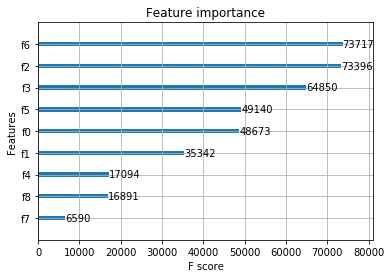

In [106]:
### Read the Dev Labels... (For Final Evaluation, we will replace it with the Test Data)

accuracy = compute_accuracy(result, dev_labels2)
print("Accuracy Dev 2 = ", accuracy)
plot_importance(classifier)
pyplot.show()

In [107]:
## Result of the model...
t1 = time.time()
result,classifier = disambiguate_mentions(train_mentions, train_labels, dev_mentions, 
                                             men_docs, parsed_entity_pages)
print('time taken: ', time.time() - t1)

KeyboardInterrupt: 

In [ ]:
### Read the Dev Labels... (For Final Evaluation, we will replace it with the Test Data)

accuracy = compute_accuracy(result, dev_labels)
print("Accuracy Dev= ", accuracy)
plot_importance(classifier)
pyplot.show()